In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

## 3.1 Автоматическое дифференцирование в `torch`

3.1.1 Воспользовавшись классами `Neuron` и `SquaredLoss` из задачи 2.4.1 и автоматическим дифференцированием, которое предоставляет `torch`, решить задачу регрессии. Для оптимизации использовать стохастический градиетный спуск.

In [ ]:
from sklearn.datasets import make_regression

X, y, coef = make_regression(n_features=4, n_informative=4, coef=True, bias=0.5)
X = torch.from_numpy(X).to(dtype=torch.float32)
y = torch.from_numpy(y).to(dtype=torch.float32)

In [ ]:
class Neuron:
    def __init__(self, n_features):
        # <создать атрибуты объекта weights и bias>
        self.w = torch.randn(n_features, requires_grad=True)
        self.b = torch.randn(1, requires_grad=True)

    def forward(self, inputs):
        # <реализовать логику нейрона>
        self.inputs = inputs
        y_pred = torch.dot(inputs, self.w)+self.b
        return y_pred

    def backward(self):
        # dvalue - значение производной, которое приходит нейрону от следующего слоя сети
        # в данном случае это будет значение df/dc (созданное методом backwards у объекта MSELoss)
        self.dw = self.w.grad
        self.db = self.b.grad

In [ ]:
class SquaredLoss:
    def forward(self, y_pred, y_true):
        self.loss = (y_pred - y_true)**2
        return self.loss

    def backward(self):
        self.loss.backward()

In [ ]:
n_inputs = X.shape[-1]
learning_rate = 0.1
n_epoch = 100

neuron = Neuron(n_inputs)
loss = SquaredLoss()

In [ ]:
neuron.w, neuron.b

(tensor([-0.8711,  0.1284, -0.2308,  0.3500], requires_grad=True),
 tensor([-0.5286], requires_grad=True))

In [ ]:
losses = []
for epoch in range(100):
    for x_example, y_example in zip(X, y):
        y_pred = neuron.forward(x_example)
        curr_loss = loss.forward(y_pred, y_example)
        losses.append(curr_loss.item())
        loss.backward()
        neuron.backward()
        with torch.no_grad():
            neuron.w -= learning_rate * neuron.dw
            neuron.b -= learning_rate * neuron.db
        neuron.w.grad.zero_()
        neuron.b.grad.zero_()

In [ ]:
neuron.w, neuron.b

(tensor([67.9244, 43.2386, 46.9046, 30.5078], requires_grad=True),
 tensor([0.5000], requires_grad=True))

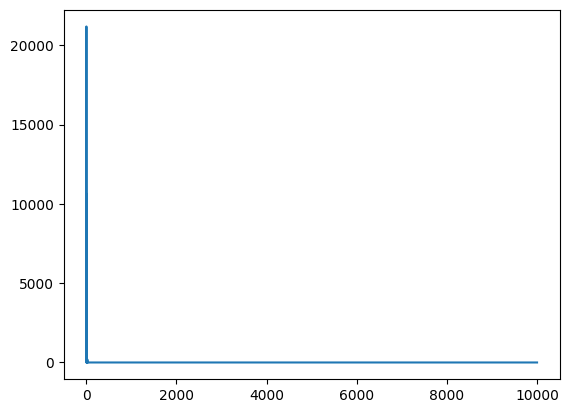

In [ ]:
plt.plot(losses);

3.1.2 Воспользовавшись классами `Linear` и `MSELoss` из задачи 2.1.4 и 2.3.1, `ReLU` из 2.2.1 и автоматическим дифференцированием, которое предоставляет `torch`, решить задачу регрессии. Для оптимизации использовать пакетный градиентный спуск. Вывести график функции потерь в зависимости от номера эпохи. Вывести на одном графике исходные данные и предсказанные значения.

In [ ]:
class Linear:
    def __init__(self, n_features, n_neurons):
        self.weights = torch.randn(n_features, n_neurons, requires_grad=True)
        self.biases = torch.randn(n_neurons, requires_grad=True)

    def forward(self, inputs):
        y_pred = inputs @ self.weights + self.biases
        return y_pred

    def backward(self):
        self.dweights = self.weights.grad # df/dW
        self.dbiases = self.biases.grad # df/db

In [ ]:
class MSELoss:
    def forward(self, y_pred, y_true):
        self.loss = torch.mean(torch.pow(y_pred - y_true, 2))
        return self.loss

    def backward(self):
        self.loss.backward()

In [ ]:
class ReLU:
    def forward(self, inputs):
        return torch.where(inputs < 0, 0, inputs)

In [ ]:
X_2 = torch.linspace(0, 1, 100).view(-1, 1)
y_2 = torch.sin(2 * np.pi * X_2) + 0.1 * torch.rand(X_2.size())

In [ ]:
## создание компонентов сети
fc1 = Linear(1, 5)
fc2 = Linear(5, 3)
fc3 = Linear(3, 1)
relu = ReLU()
loss = MSELoss()
lr = 0.1

In [ ]:
fc1.weights, fc1.biases

(tensor([[-1.4706,  0.8075,  0.7868,  0.0648,  0.1726]], requires_grad=True),
 tensor([-0.7430,  0.9246, -0.0729, -0.1697, -1.7415], requires_grad=True))

In [ ]:
losses = []
y_pred_lst = []
for epoch in range(10001):
    y_pred = fc3.forward(fc2.forward(relu.forward(fc1.forward(X_2))))
    curr_loss = loss.forward(y_pred, y_2)
    losses.append(curr_loss.item())
    loss.backward()
    fc1.backward()
    fc2.backward()
    fc3.backward()
    if epoch % 500 == 0:
        y_pred_lst.append(y_pred)
        print(f'{epoch}: {curr_loss}')
    with torch.no_grad():
        fc1.weights -= learning_rate * fc1.dweights
        fc1.biases -= learning_rate * fc1.dbiases
        fc2.weights -= learning_rate * fc2.dweights
        fc2.biases -= learning_rate * fc2.dbiases
        fc3.weights -= learning_rate * fc3.dweights
        fc3.biases -= learning_rate * fc3.dbiases
    fc1.weights.grad.zero_()
    fc1.biases.grad.zero_()
    fc2.weights.grad.zero_()
    fc2.biases.grad.zero_()
    fc3.weights.grad.zero_()
    fc3.biases.grad.zero_()

0: 1.5215541124343872
500: 0.1639307737350464
1000: 0.16513435542583466
1500: 0.1651964634656906
2000: 0.1640533059835434
2500: 0.16155193746089935
3000: 0.1592051386833191
3500: 0.15691933035850525
4000: 0.1553606390953064
4500: 0.15325632691383362
5000: 0.15284158289432526
5500: 0.15181270241737366
6000: 0.16077417135238647
6500: 0.15595285594463348
7000: 0.1468064934015274
7500: 0.14708326756954193
8000: 0.14711010456085205
8500: 0.14797957241535187
9000: 0.14456304907798767
9500: 0.1434677243232727
10000: 0.14440765976905823


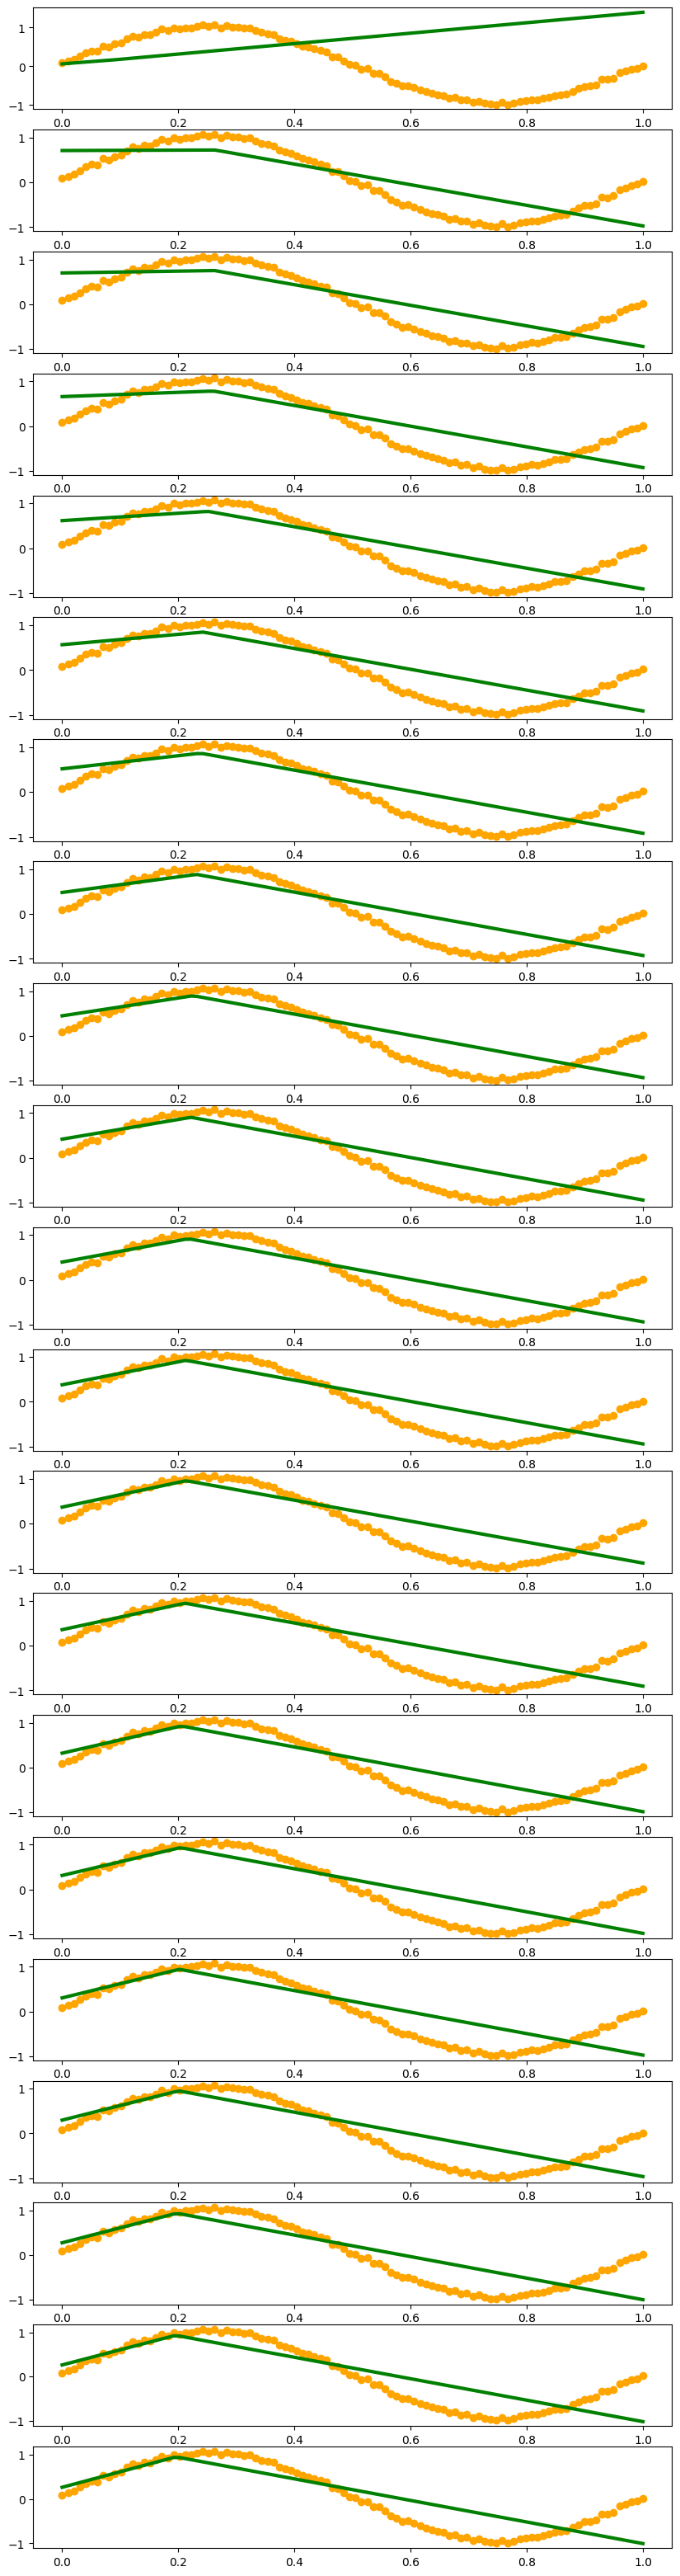

In [ ]:
fig, axs = plt.subplots(len(y_pred_lst), 1, figsize=(10, 40))

for ax, y_ in zip(axs, y_pred_lst):
    ax.scatter(X_2.detach().numpy(), y_2.detach().numpy(), color="orange")
    ax.plot(X_2.detach().numpy(), y_.detach().numpy(), 'g-', lw=3)

plt.show()

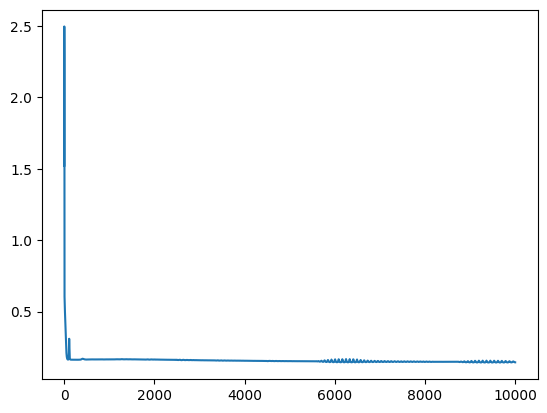

In [ ]:
plt.plot(losses);

## 3.2 Алгоритмы оптимизации в `torch.optim`

In [ ]:
import torch.optim as optim

In [ ]:
X, y, coef = make_regression(n_features=4, n_informative=4, coef=True, bias=0.5)
X = torch.from_numpy(X).to(dtype=torch.float32)
y = torch.from_numpy(y).to(dtype=torch.float32)
fc1 = Linear(X.shape[-1], 10)
fc2 = Linear(10, 5)
fc3 = Linear(5, 1)
relu = ReLU()
loss = MSELoss()
lr = 0.1

In [ ]:
optimizer = optim.SGD([fc1.weights, fc1.biases, fc2.weights, fc2.biases, fc3.weights, fc3.biases], lr=lr)

3.2.1 Решить задачу 3.1.1, воспользовавшись оптимизатором `optim.SDG` для применения стохастического градиентого спуска

In [ ]:
losses, y_pred_lst = [], []
for epoch in range(1001):
    for x_example, y_example in zip(X, y):
        y_pred = fc3.forward(fc2.forward(relu.forward(fc1.forward(X))))
        curr_loss = loss.forward(y_pred, y_example)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    if epoch % 200 == 0:
        print(f'{epoch}: {curr_loss}')
        y_pred_lst.append(y_pred)
    losses.append(curr_loss.item())

0: nan
200: nan
400: nan
600: nan
800: nan
1000: nan


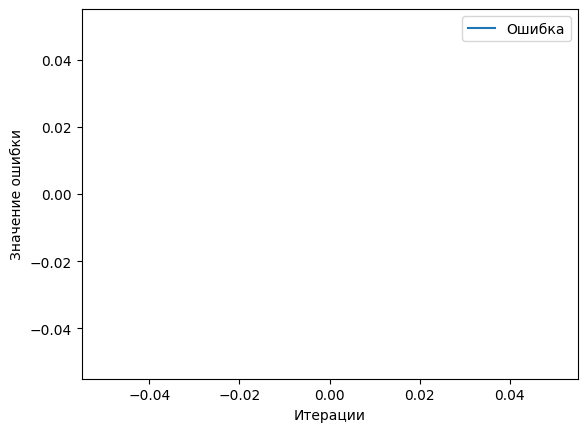

In [ ]:
plt.plot(range(len(losses)), losses, label='Ошибка')
plt.xlabel('Итерации')
plt.ylabel('Значение ошибки')
plt.legend()
plt.show()

3.2.2 Решить задачу 3.1.2, воспользовавшись оптимизатором `optim.Adam` для применения пакетного градиентого спуска. Вывести график функции потерь в зависимости от номера эпохи. Вывести на одном графике исходные данные и предсказанные значения.

In [ ]:
fc1 = Linear(1, 30)
fc2 = Linear(30, 20)
fc3 = Linear(20, 1)

In [ ]:
X = torch.linspace(0, 1, 100).view(-1, 1)
y = torch.sin(2 * np.pi * X) + 0.1 * torch.rand(X.size())

In [ ]:
relu = ReLU()
loss = MSELoss()
y_pred_lst = []
optimizer = optim.Adam([fc1.weights, fc1.biases, fc2.weights, fc2.biases, fc3.weights, fc3.biases], lr=0.01)

losses = []
for epoch in range(10001):
    y_pred = fc3.forward(fc2.forward(relu.forward(fc1.forward(X))))
    curr_loss = loss.forward(y_pred, y)
    if epoch % 1000 == 0:
        y_pred_lst.append(y_pred)
        print(f'{epoch}: {curr_loss}')
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

0: 2546.926513671875
1000: 0.01753406412899494
2000: 0.007888986729085445
3000: 0.00413849763572216
4000: 0.003705260343849659
5000: 0.003177240490913391
6000: 0.002033994533121586
7000: 0.0016243553254753351
8000: 0.0058388845063745975
9000: 0.0014225727645680308
10000: 0.001287243328988552


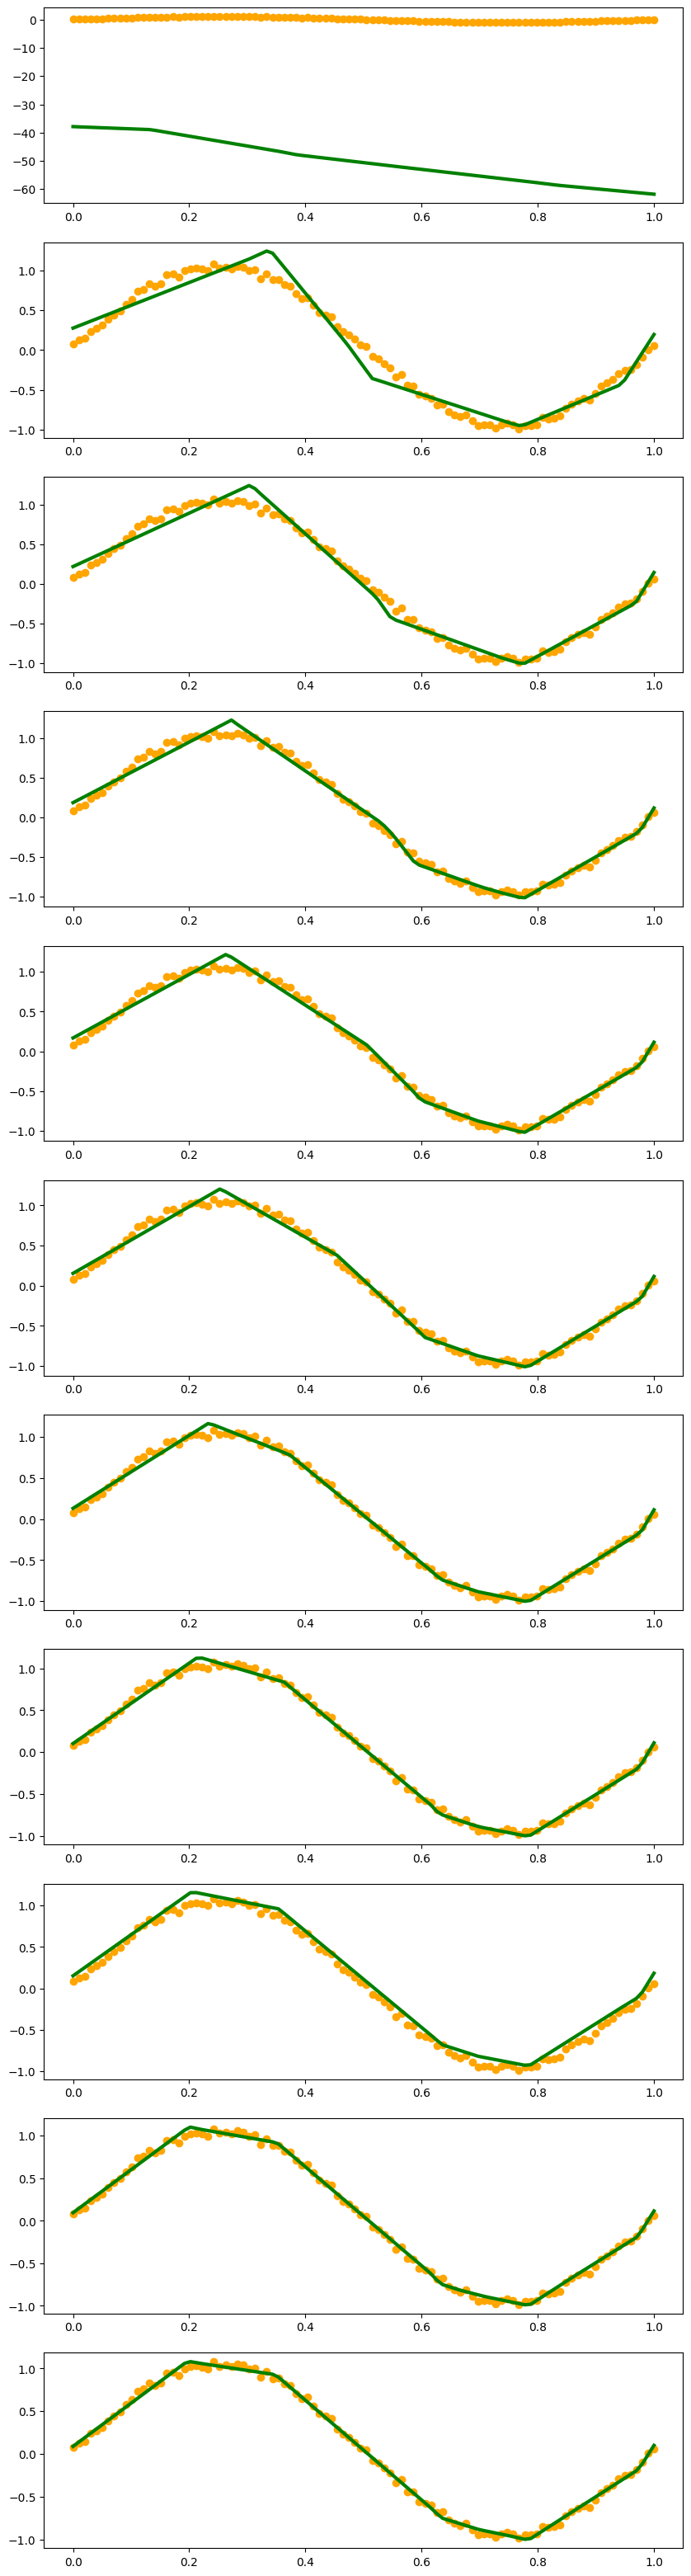

In [ ]:
fig, axs = plt.subplots(len(y_pred_lst), 1, figsize=(10, 40))

for ax, y_ in zip(axs, y_pred_lst):
    ax.scatter(X.detach().numpy(), y.detach().numpy(), color="orange")
    ax.plot(X.detach().numpy(), y_.detach().numpy(), 'g-', lw=3)

plt.show()

## 3.3 Построение сетей при помощи `torch.nn`

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

3.3.1 Решить задачу регрессии, соблюдая следующие условия:

1. Оформить нейронную сеть в виде класса - наследника `nn.Module`
2. При создании сети использовать готовые блоки из `torch.nn`: слои, функции активации, функции потерь и т.д.
3. Для оптимизации использовать любой алгоритм оптимизации из `torch.optim`

In [ ]:
class Net (nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(1, 10)
        self.fc2 = nn.Linear(10, 5)
        self.fc3 = nn.Linear(5, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x1 = self.fc1(x)
        x2 = self.relu(x1)
        x3 = self.fc2(x2)
        x4 = self.fc3(x3)
        return x4

In [ ]:
X = torch.linspace(0, 1, 100).view(-1, 1)
y = torch.sin(2 * np.pi * X) + 0.1 * torch.rand(X.size())

In [ ]:
net = Net()

criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=0.01)

num_epochs = 10001
losses = []

for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = net(X)
    loss = criterion(outputs, y)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    if epoch % 1000 == 0:
        print(f'{epoch}: {loss.item()}')

0: 0.7618626356124878
1000: 0.17811313271522522
2000: 0.17534227669239044
3000: 0.1730913370847702
4000: 0.1712920069694519
5000: 0.16981197893619537
6000: 0.16859424114227295
7000: 0.1676030158996582
8000: 0.16677257418632507
9000: 0.16604571044445038
10000: 0.16536344587802887


In [ ]:
def predict(net, X, y):
        y_pred = net.forward(X)
        plt.figure(figsize=(10, 5))
        plt.plot(X.numpy(), y.numpy(), 'o')
        plt.plot(X.numpy(), y_pred.data.numpy(), 'x', c='r');

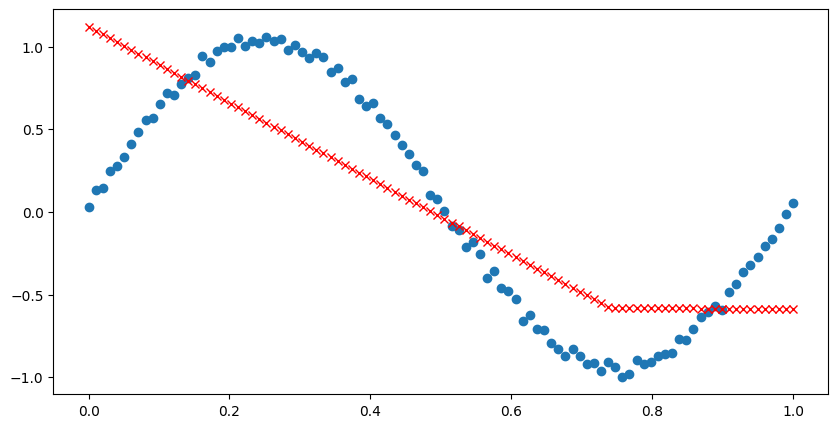

In [ ]:
predict(net, X, y)

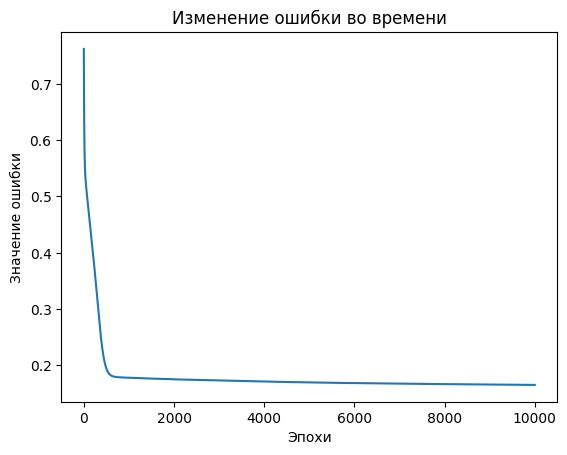

In [ ]:
plt.plot(range(num_epochs), losses)
plt.xlabel('Эпохи')
plt.ylabel('Значение ошибки')
plt.title('Изменение ошибки во времени')
plt.show()

In [ ]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
criterion = nn.MSELoss()
losses = []

0: 0.14337363839149475
1000: 0.14335991442203522
2000: 0.1438344568014145
3000: 0.1433599591255188
4000: 0.14336013793945312
5000: 0.1433599591255188
6000: 0.14336048066616058
7000: 0.1434556245803833
8000: 0.14336033165454865
9000: 0.1433657705783844
10000: 0.14336960017681122


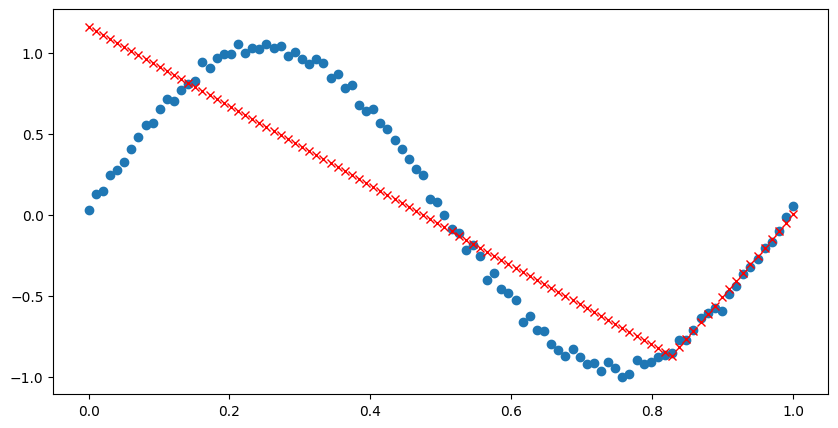

In [ ]:
for epoch_index in range(10001):
    y_pred = net.forward(X)
    loss_val = criterion.forward(y_pred, y)
    loss_val.backward()
    optimizer.step()
    optimizer.zero_grad()
    losses.append(loss_val.item())
    if epoch_index % 1000 == 0:
        print(f'{epoch_index}: {loss_val.item()}')

predict(net, X, y)

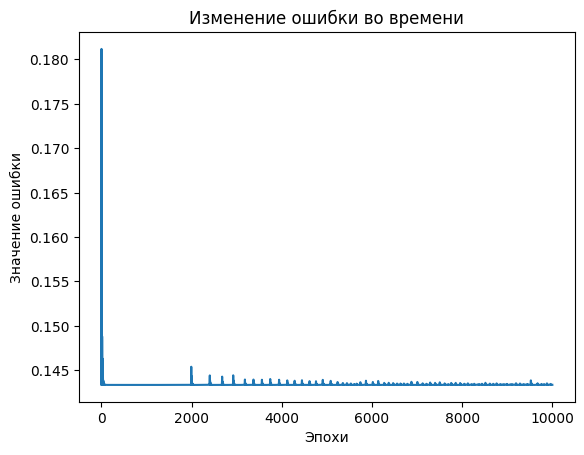

In [ ]:
plt.plot(range(num_epochs), losses)
plt.xlabel('Эпохи')
plt.ylabel('Значение ошибки')
plt.title('Изменение ошибки во времени')
plt.show()

3.3.2 Решить задачу регрессии, соблюдая следующие условия:

1. Оформить нейронную сеть в виде объекта `nn.Sequential`
2. При создании сети использовать готовые блоки из `torch.nn`: слои, функции активации, функции потерь и т.д.
3. Для оптимизации использовать любой алгоритм оптимизации из `torch.optim`

In [ ]:
X = torch.linspace(0, 1, 100).view(-1, 1)
y = torch.sin(2 * np.pi * X) + 0.1 * torch.rand(X.size())

In [ ]:
model = nn.Sequential(
    nn.Linear(1, 10),
    nn.ReLU(),
    nn.Linear(10,5),
    nn.Linear(5,1)
)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
criterion = nn.MSELoss()
losses = []

0: 0.43210095167160034
1000: 0.00829355325549841
2000: 0.011277024634182453
3000: 0.01081254705786705
4000: 0.019939208403229713
5000: 0.00772899528965354
6000: 0.008485890924930573
7000: 0.007039351388812065
8000: 0.006614022422581911
9000: 0.051184821873903275
10000: 0.007244868203997612


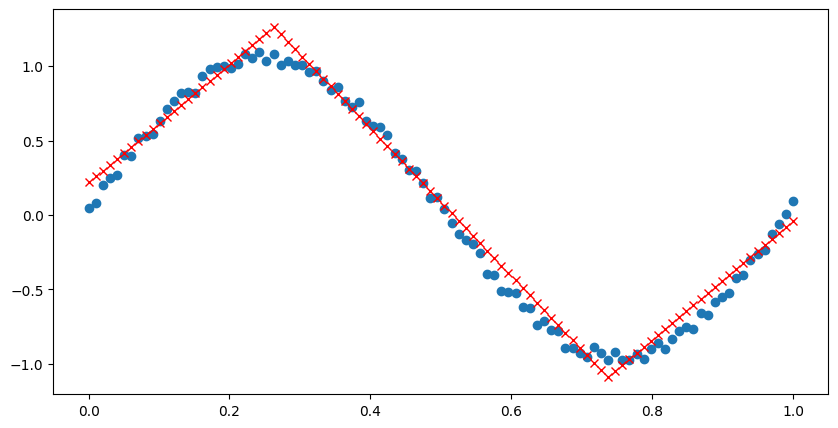

In [ ]:
for epoch_index in range(10001):
    y_pred = model.forward(X)
    loss_val = criterion.forward(y_pred, y)
    loss_val.backward()
    optimizer.step()
    optimizer.zero_grad()
    losses.append(loss_val.item())
    if epoch_index % 1000 == 0:
        print(f'{epoch_index}: {loss_val.item()}')

predict(model, X, y)

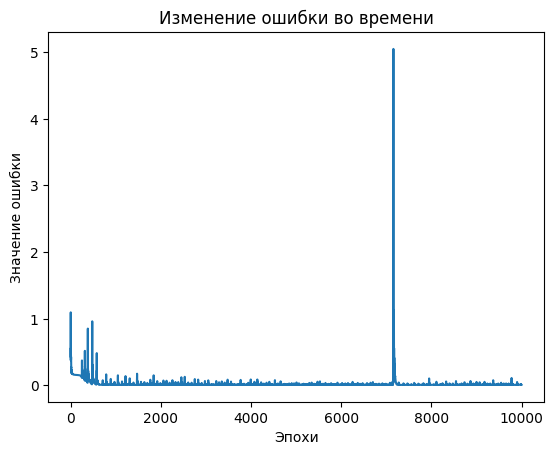

In [ ]:
plt.plot(range(num_epochs), losses)
plt.xlabel('Эпохи')
plt.ylabel('Значение ошибки')
plt.title('Изменение ошибки во времени')
plt.show()

## 3.4. Datasets and dataloaders

In [ ]:
from torch.utils.data import Dataset, DataLoader

3.4.1 Создать датасет, поставляющий данные из задачи 3.1.2.

Создать `DataLoader` на основе этого датасета и проверить работоспособность.

Воспользовавшись результатами 3.3.1 (или 3.3.2) обучите модель, пользуясь мини-пакетным градиентным спуском с размером пакета (`batch_size`) = 10

In [ ]:
class SinDataset(Dataset):
    def __init__(self):
        self.n_samples = X.shape[0]
        self.X = X
        self.y = y

    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [ ]:
model = nn.Sequential(
    nn.Linear(1, 10),
    nn.ReLU(),
    nn.Linear(10,5),
    nn.Linear(5, 1)
)

In [ ]:
dataset = SinDataset()
dataloader = DataLoader(dataset, batch_size=10)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

0: 0.004868587478995323
1000: 0.001601613825187087
2000: 0.004750341176986694
3000: 0.0024254233576357365
4000: 0.0026001608930528164
5000: 0.002151090418919921
6000: 0.0056108832359313965
7000: 0.010074802674353123
8000: 0.0028598764911293983
9000: 0.005985523574054241
10000: 0.005460485350340605


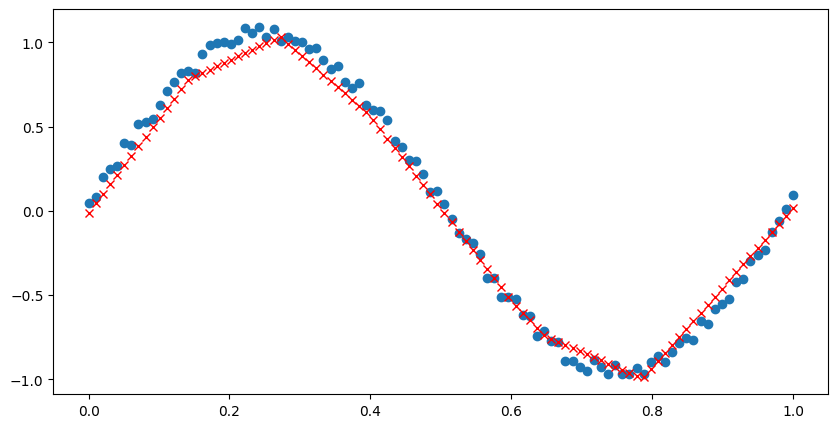

In [ ]:
for epoch_index in range(10001):
    for x_example, y_example in dataloader:
        y_pred = model.forward(x_example)
        loss_val = criterion.forward(y_pred, y_example)
        loss_val.backward()
        optimizer.step()
        optimizer.zero_grad()
    if epoch_index % 1000 == 0:
        print(f'{epoch_index}: {loss_val.item()}')

predict(model, X, y)

3.4.2 Предсказание цен алмазов

3.4.2.1 Создайте датасет на основе файла diamonds.csv.

1. Удалите все нечисловые столбцы
2. Целевой столбец (`y`) - `price`
3. Преобразуйте данные в тензоры корректных размеров

3.4.2.2 Разбейте датасет на обучающий и тестовый датасет при помощи `torch.utils.data.random_split`.

3.4.2.3 Обучите модель для предсказания цен при помощи мини-пакетного градиентного спуска (`batch_size = 256`).

3.4.2.4 Выведите график функции потерь в зависимости от номера эпохи (значение потерь для эпохи рассчитывайте как среднее значение ошибок на каждом батче). Проверьте качество модели на тестовой выборке.


In [ ]:
import pandas as pd

diamonds = pd.read_csv('diamonds.csv', index_col=0)
diamonds.head(5)

,carat,cut,color,clarity,depth,table,price,x,y,z
1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [ ]:
diamonds.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53940 entries, 1 to 53940
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    53940 non-null  float64
 1   cut      53940 non-null  object 
 2   color    53940 non-null  object 
 3   clarity  53940 non-null  object 
 4   depth    53940 non-null  float64
 5   table    53940 non-null  float64
 6   price    53940 non-null  int64  
 7   x        53940 non-null  float64
 8   y        53940 non-null  float64
 9   z        53940 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 4.5+ MB


In [ ]:
class DiamondsDataset(Dataset):
    def __init__(self, data):
        data = data.select_dtypes(exclude='object')
        self.x = torch.from_numpy(data.drop("price", axis=1).values).float()
        self.y = torch.from_numpy(data[["price"]].values).float()
        self.n_samples = self.x.shape[0]

    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [ ]:
dataset = DiamondsDataset(diamonds)
train, test = torch.utils.data.random_split(dataset, [0.8, 0.2])
dataloader = DataLoader(dataset=train, batch_size=256)

model = nn.Sequential(
    nn.Linear(dataset.x.shape[-1], 200),
    nn.ReLU(),
    nn.Linear(200, 20),
    nn.Linear(20,1)
)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

In [ ]:
losses_all = []
for epoch in range(101):
    losses = torch.empty(0)
    for x_example, y_example in dataloader:
        y_pred = model(x_example)
        loss = criterion(y_pred, y_example)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        losses = torch.cat((losses, loss.view(1)))

    if epoch % 20 == 0:
        print('epoch', epoch, 'loss', losses.mean().item())
    losses_all.append(losses.mean().item())
    losses_train = losses

epoch 0 loss 13465159.0
epoch 20 loss 2146002.5
epoch 40 loss 2060306.875
epoch 60 loss 2017111.625
epoch 80 loss 2006644.25
epoch 100 loss 2001061.875


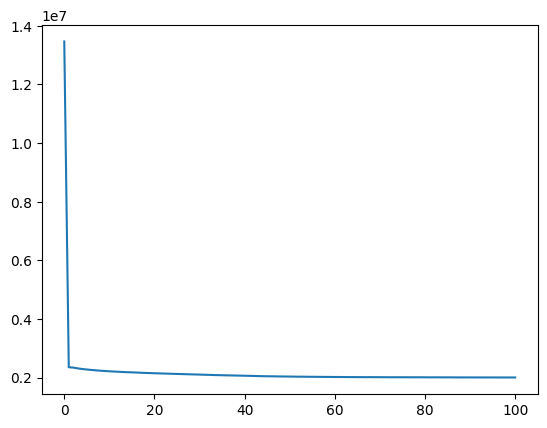

In [ ]:
plt.plot(losses_all)

In [ ]:
dataloader = DataLoader(dataset=test, batch_size=256)
losses_test = torch.empty(0)
for x_example, y_example in dataloader:
    y_pred = model(x_example)
    loss = criterion(y_pred, y_example)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    losses_test = torch.cat((losses_test, loss.view(1)))

print(losses_test.mean().item())

2110650.25


(0.0, 70.0)

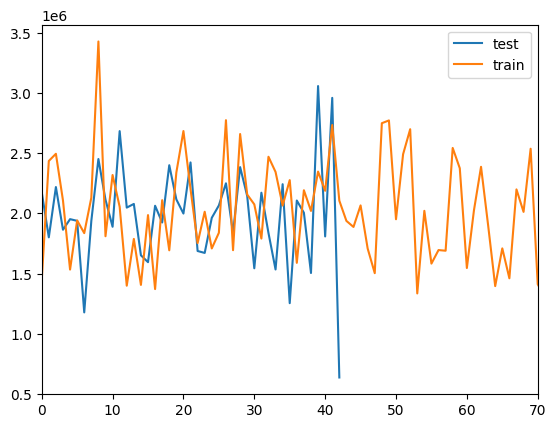

In [ ]:
plt.plot(losses_test.detach().numpy(), label='test')
plt.plot(losses_train.detach().numpy(), label='train')
plt.legend()
plt.xlim(0,70)

3.4.3 Модифицируйте метод `__init__` датасета из 3.4.2 таким образом, чтобы он мог принимать параметр `transform: callable`. Реализуйте класс `DropColsTransform` для удаления нечисловых данных из массива. Реализуйте класс `ToTensorTransorm` для трансформации массива в тензор.

In [ ]:
class DiamondsDataset(Dataset):
    def __init__(self, data, transform):
        self.n_samples = data.shape[0]
        self.transform = transform
        self.x = data.drop("price", axis=1).values
        self.y = data[["price"]].values

    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx):
        sample = self.x[idx], self.y[idx]
        if self.transform:
            sample = self.transform(sample)
        return sample

In [ ]:
class DropColsTransform:
    def __init__(self, drop):
        self.drop = drop

    def __call__(self, sample):
        X, y = sample
        X = np.delete(X, self.drop, 0)
        return X, y

In [ ]:
class ToTensorTransform:
    def __call__(self, sample):
        X, y = sample
        X = torch.from_numpy(X.astype("float")).float()
        y = torch.from_numpy(y.astype("float")).float()
        return X, y

In [ ]:
diamonds.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [ ]:
from torchvision import transforms

drop = DropColsTransform(drop=[1, 2, 3])
to_tensor = ToTensorTransform()
dataset = DiamondsDataset(diamonds, transforms.Compose([drop, to_tensor]))

In [ ]:
train, test = torch.utils.data.random_split(dataset, [0.8, 0.2])
dataloader = DataLoader(dataset=train, batch_size=256)

model = nn.Sequential(
    nn.Linear(dataset.x.shape[-1]-3, 200),
    nn.ReLU(),
    nn.Linear(200, 20),
    nn.Linear(20, 1),
)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

In [ ]:
losses_all = []
for epoch_ind in range(101):
    losses = torch.empty(0)
    for x_example, y_example in dataloader:
        y_pred = model(x_example)
        loss = criterion(y_pred, y_example)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        losses = torch.cat((losses, loss.view(1)))

    if epoch_ind % 20 == 0:
        print('epoch', epoch_ind, 'loss', losses.mean().item())
    losses_all.append(losses.mean().item())
    losses_train = losses

epoch 0 loss 2131093.5
epoch 20 loss 2064167.75
epoch 40 loss 2031575.25
epoch 60 loss 2017946.5
epoch 80 loss 2011693.125
epoch 100 loss 2002831.5


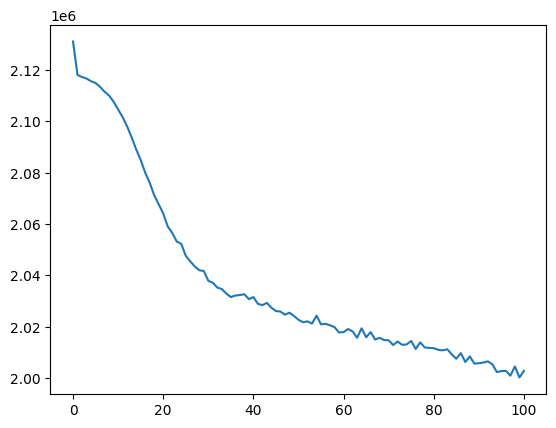

In [ ]:
plt.plot(losses_all)

In [ ]:
dataloader = DataLoader(dataset=test, batch_size=256)
losses_test = torch.empty(0)
for x_example, y_example in dataloader:
    y_pred = model(x_example)
    loss = criterion(y_pred, y_example)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    losses_test = torch.cat((losses_test, loss.view(1)))

print(losses_test.mean().item())

1981350.75


(0.0, 70.0)

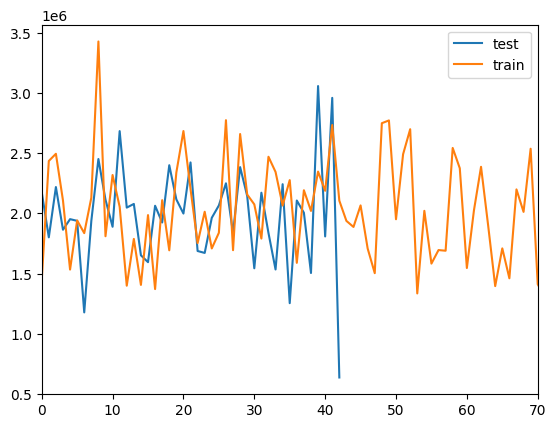

In [ ]:
plt.plot(losses_test.detach().numpy(), label='test')
plt.plot(losses_train.detach().numpy(), label='train')
plt.legend()
plt.xlim(0,70)